# Test effect of experiments

Notebook test the effect of experiments using *P. aeruginosa* gene expression data.

**Explain more here**

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import ast
import pandas as pd
import numpy as np
import random
from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='ignore')

from simulate_expression_compendia_modules import pipeline
from ponyo import utils, train_vae_modules

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs", 
                                           "config_Pa_test_experiment_effect.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
correction_method = params["correction_method"]
num_simulated_experiments = params["num_simulated_experiments"]
train_architecture = params['NN_architecture']

In [4]:
# Input files
normalized_processed_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "train_set_normalized_processed.txt.xz")

experiment_id_file = os.path.join(
    base_dir, 
    dataset_name,
    "data",
    "metadata", 
    "experiment_ids.txt")

metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "sample_annotations.tsv")

## Run simulation experiment

In [5]:
# Run simulation without correction 

# Initialize lists to keep track of results to plot
mean_uncorrected_scores = []
mean_corrected_scores = []
ci_uncorrected_min = []
ci_uncorrected_max = []
ci_corrected_min = []
ci_corrected_max = []
permuted_uncorrected_scores = []

for size_simulated_compendia in num_simulated_experiments:
    lst_num_partitions = [1,size_simulated_compendia]
    
    # Run simulation comparing compendia with `size_simulated_compendia` experiments
    # with the same size compendia with `size_simulated_compendia` partitions
    corrected=False
    (uncorrected_mean_scores,
     ci_uncorrected,
     permuted_score,
     corrected_mean_scores,
     ci_corrected) = pipeline.run_experiment_effect_simulation(config_file,
                                                               normalized_processed_data_file,
                                                               size_simulated_compendia,
                                                               lst_num_partitions,
                                                               corrected,
                                                               experiment_id_file)
       
    # Run simulation comparing compendia with `size_simulated_compendia` partitions
    # with the compendia after applying batch correction for the number of partitions
    #corrected=True
    #(corrected_mean_score, 
    # ci_corrected, 
    # corrected_permuted_score) = pipeline.run_experiment_effect_simulation(config_file,
    #                                                                       normalized_processed_data_file,
    #                                                                       size_simulated_compendia,
    #                                                                       lst_num_partitions,
    #                                                                       corrected,
    #                                                                       experiment_id_file)
    
    mean_uncorrected_scores.append(uncorrected_mean_scores.loc[size_simulated_compendia,'score'])
    ci_uncorrected_min.append(ci_uncorrected.loc[size_simulated_compendia, 'ymin'])
    ci_uncorrected_max.append(ci_uncorrected.loc[size_simulated_compendia, 'ymax'])
    permuted_uncorrected_scores.append(permuted_score)
    mean_corrected_scores.append(corrected_mean_scores.loc[size_simulated_compendia,'score'])
    ci_corrected_min.append(ci_corrected.loc[size_simulated_compendia, 'ymin'])
    ci_corrected_max.append(ci_corrected.loc[size_simulated_compendia, 'ymax']) 
     

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   16.7s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   18.1s remaining:   27.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   18.3s remaining:   12.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   21.0s finished
mean uncorrected svcca scores
                         score
number of partitions          
1                     0.999935
2                     0.999709
mean corrected svcca scores
                         score
number of partitions          
1                     0.999935
2                     0.900514
uncorrected confidence interval
       ymin      ymax
1  0.999911  0.999982
2  0.999333  0.999898
corrected_confidence interval
       ymin      ymax
1  0.999911  0.999982
2  0.899430  0.902451
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5

## Make figures

In [6]:
# Output files
svcca_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_svcca_"+correction_method+".svg")

svcca_png_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_svcca_"+correction_method+".png")

pca_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_pca_uncorrected_"+correction_method+".svg")

pca_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_pca_corrected_"+correction_method+".svg")

In [7]:
# Create df
uncorrected_df = pd.DataFrame(data={'Compendia size': num_simulated_experiments,
                                    'SVCCA score': mean_uncorrected_scores,
                                    'ymin': ci_uncorrected_min,
                                    'ymax': ci_uncorrected_max,
                                    'group': 'uncorrected'
                               }).set_index('Compendia size')

corrected_df = pd.DataFrame(data={'Compendia size': num_simulated_experiments,
                                  'SVCCA score': mean_corrected_scores,
                                  'ymin': ci_corrected_min,
                                  'ymax': ci_corrected_max,
                                  'group': 'corrected'
                
                               }).set_index('Compendia size')

summary_df = pd.concat([uncorrected_df, corrected_df])

summary_df.head()

,SVCCA score,ymin,ymax,group
Compendia size,,,,
2,0.999709,0.999333,0.999898,uncorrected
3,0.998858,0.996754,0.999818,uncorrected
2,0.900514,0.899430,0.902451,corrected
3,0.806037,0.803547,0.813190,corrected


### SVCCA 

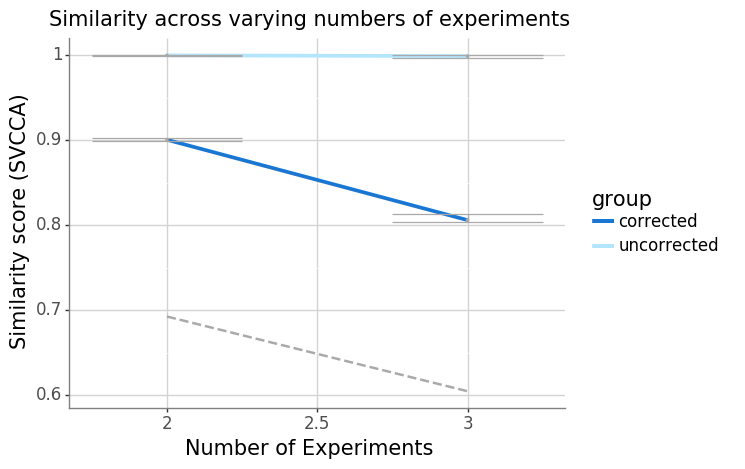

<ggplot: (8757053884150)>


In [8]:
# Plot
lst_num_partitions = list(summary_df.index)

threshold = pd.DataFrame(permuted_uncorrected_scores,
                         index=num_simulated_experiments,
                         columns=['score'])

panel_A = ggplot(summary_df) \
    + geom_line(summary_df,
                aes(x=lst_num_partitions, y='SVCCA score', color='group'),
                size=1.5) \
    + geom_point(aes(x=lst_num_partitions, y='SVCCA score'), 
                 color ='darkgrey',
                 size=0.5) \
    + geom_errorbar(summary_df,
                    aes(x=lst_num_partitions, ymin='ymin', ymax='ymax'),
                    color='darkgrey') \
    + geom_line(threshold, 
                aes(x=num_simulated_experiments, y='score'), 
                linetype='dashed',
                size=1,
                color="darkgrey",
                show_legend=False) \
    + labs(x = "Number of Experiments", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity across varying numbers of experiments") \
    + theme(
            plot_background=element_rect(fill="white"),
            panel_background=element_rect(fill="white"),
            panel_grid_major_x=element_line(color="lightgrey"),
            panel_grid_major_y=element_line(color="lightgrey"),
            axis_line=element_line(color="grey"),
            legend_key=element_rect(fill='white', colour='white'),
            legend_title=element_text(family='sans-serif', size=15),
            legend_text=element_text(family='sans-serif', size=12),
            plot_title=element_text(family='sans-serif', size=15),
            axis_text=element_text(family='sans-serif', size=12),
            axis_title=element_text(family='sans-serif', size=15)
           ) \
    + scale_color_manual(['#1976d2', '#b3e5fc']) \


print(panel_A)
ggsave(plot=panel_A, filename=svcca_file, device="svg", dpi=300)
ggsave(plot=panel_A, filename=svcca_png_file, device="svg", dpi=300)
    

### Uncorrected PCA

In [9]:
# File directories
compendia_dir = os.path.join(
    local_dir,
    "partition_simulated",
    dataset_name + "_" + analysis_name)

In [10]:
lst_num_partitions_to_plot = [lst_num_partitions[-1]]

all_data_df = pd.DataFrame()

# Get batch 1 data
# This compendia contains all experiments in a single batch
# Since we keep overwriting our `Partition_` files we can
# only plot a compendia using the last `num_simulated_experiments`
partition_1_file = os.path.join(
    compendia_dir,
    "Partition_1_0.txt.xz")

partition_1 = pd.read_table(
    partition_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_partitions_to_plot:
    print('Plotting PCA of 1 parition vs {} partition...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  partition_1.copy()
    
    # Add grouping column for plotting
    original_data_df['num_partitions'] = '1'
    
    # Get data with additional batch effects added
    partition_other_file = os.path.join(
        compendia_dir,
        "Partition_"+str(i)+"_0.txt.xz")

    partition_other = pd.read_table(
        partition_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    partition_data_df =  partition_other
    
    # Add grouping column for plotting
    partition_data_df['num_partitions'] = 'multiple'
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, partition_data_df])

    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['num_partitions'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
                                              
    # Variance explained
    print(pca.explained_variance_ratio_)  
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_partitions'] = combined_data_df['num_partitions']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])     

Plotting PCA of 1 parition vs 3 partition...
[0.38281344 0.2312705 ]


In [11]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_partitions_str = [str(i) for i in lst_num_partitions_to_plot]
num_partitions_cat = pd.Categorical(all_data_df['num_partitions'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_data_df['comparison'], categories=lst_num_partitions_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_partitions_cat = num_partitions_cat)
all_data_df = all_data_df.assign(comparison_cat = comparison_cat)

In [12]:
all_data_df.columns = ['PC1', 'PC2', 'num_partitions', 'comparison', 'No. of partitions', 'Comparison']

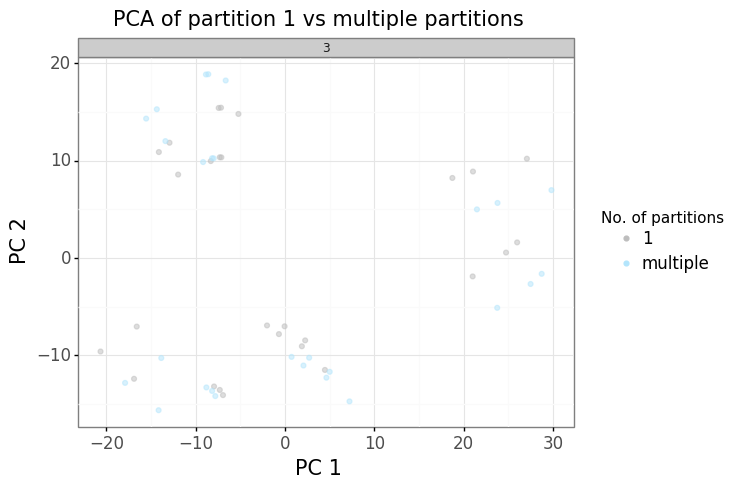

<ggplot: (8757053595470)>


In [13]:
# Plot all comparisons in one figure
panel_B = ggplot(all_data_df[all_data_df['Comparison'] != '1'],
                 aes(x='PC1', y='PC2')) \
    + geom_point(aes(color='No. of partitions'), 
                 alpha=0.5) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1", 
           y = "PC 2", 
           title = "PCA of partition 1 vs multiple partitions") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        legend_text=element_text(family='sans-serif', size=12),
        plot_title=element_text(family='sans-serif', size=15),
        axis_text=element_text(family='sans-serif', size=12),
        axis_title=element_text(family='sans-serif', size=15)
    ) \
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#b3e5fc']) \
    + geom_point(data=all_data_df[all_data_df['Comparison'] == '1'],
                 alpha=0.5, 
                 color='#bdbdbd')

print(panel_B)
ggsave(plot=panel_B, filename=pca_uncorrected_file)

### Corrected PCA

In [15]:
lst_num_partitions_to_plot = [lst_num_partitions[-1]]

all_corrected_data_df = pd.DataFrame()

# Get batch 1 data
partition_1_file = os.path.join(
    compendia_dir,
    "Partition_corrected_1_0.txt.xz")

partition_1 = pd.read_table(
    partition_1_file,
    header=0,
    index_col=0,
    sep='\t')

# Transpose data to df: sample x gene
partition_1 = partition_1.T

for i in lst_num_partitions_to_plot:
    print('Plotting PCA of 1 partition vs {} partitions...'.format(i))
    
     # Simulated data with all samples in a single batch
    original_data_df =  partition_1.copy()
    
    # Match format of column names in before and after df
    original_data_df.columns = original_data_df.columns.astype(str)
    
    # Add grouping column for plotting
    original_data_df['num_partitions'] = '1'
    
    # Get data with additional batch effects added and corrected
    partition_other_file = os.path.join(
        compendia_dir,
        "Partition_corrected_"+str(i)+"_0.txt.xz")

    partition_other = pd.read_table(
        partition_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Transpose data to df: sample x gene
    partition_other = partition_other.T
    
    # Simulated data with i batch effects that are corrected
    partition_data_df =  partition_other
    
    # Add grouping column for plotting
    partition_data_df['num_partitions'] = 'multiple'
    
    # Match format of column names in before and after df
    partition_data_df.columns = original_data_df.columns.astype(str)
        
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, partition_data_df])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space    
    combined_data_numeric_df = combined_data_df.drop(['num_partitions'], axis=1)    
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)

    
    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_partitions'] = combined_data_df['num_partitions']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_corrected_data_df = pd.concat([all_corrected_data_df, combined_data_PCAencoded_df])

Plotting PCA of 1 partition vs 3 partitions...


In [16]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_partitions_str = [str(i) for i in lst_num_partitions_to_plot]
num_partitions_cat = pd.Categorical(all_corrected_data_df['num_partitions'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_corrected_data_df['comparison'], categories=lst_num_partitions_str)

# Assign to a new column in the df
all_corrected_data_df = all_corrected_data_df.assign(num_partitions_cat = num_partitions_cat)
all_corrected_data_df = all_corrected_data_df.assign(comparison_cat = comparison_cat)

In [17]:
all_corrected_data_df.columns = ['PC1', 'PC2', 'num_partitions', 'comparison', 'No. of partitions', 'Comparison']

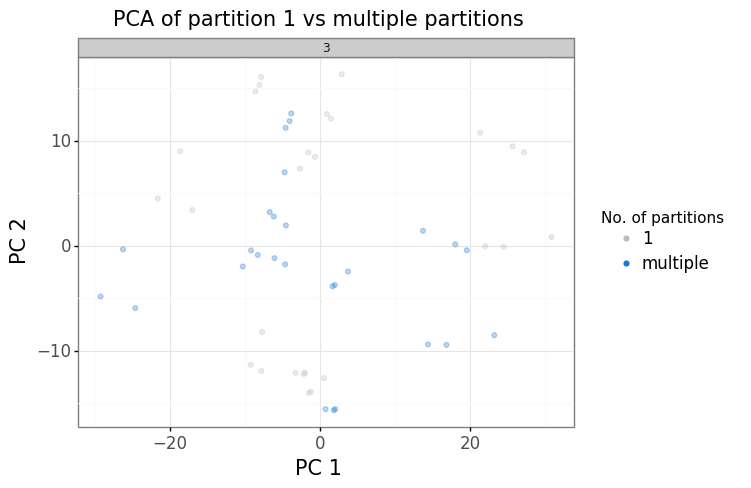

<ggplot: (-9223363279852571655)>


In [18]:
# Plot all comparisons in one figure
panel_C = ggplot(all_corrected_data_df[all_corrected_data_df['Comparison'] != '1'],
                 aes(x='PC1', 
                     y='PC2')) \
    + geom_point(aes(color='No. of partitions'), 
                 alpha=0.3) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1", 
           y = "PC 2", 
           title = "PCA of partition 1 vs multiple partitions") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        legend_text=element_text(family='sans-serif', size=12),
        plot_title=element_text(family='sans-serif', size=15),
        axis_text=element_text(family='sans-serif', size=12),
        axis_title=element_text(family='sans-serif', size=15)
    ) \
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#1976d2']) \
    + geom_point(data=all_corrected_data_df[all_corrected_data_df['Comparison'] == '1'],
                 alpha=0.3, 
                 color='#bdbdbd')

print(panel_C)
ggsave(plot=panel_C, filename=pca_corrected_file)

In [ ]:
 # Compendium directory
compendium_dir = os.path.join(
    local_dir, "experiment_simulated", "Pseudomonas_sample_lvl_sim"
)
#file = os.path.join(compendium_dir, "Experiment_corrected_1_0.txt.xz")
file = "data/input/train_set_normalized_processed.txt.xz"
data = pd.read_csv(file, sep="\t", index_col=0)

data.head(10)